In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

In [2]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

In [3]:
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names

In [4]:
def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

In [18]:
img = cv2.imread('./img/train_BRK_2052.JPG')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

In [12]:
model = torch.hub.load('./yolov5', 'custom', path='./model/yolov5-p2.pt', source='local')
model.eval()
model.cpu()

requirements: Ultralytics requirement /home/featurize/work/yolov5/requirements.txt not found, attempting AutoUpdate...
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

requirements: AutoUpdate success ✅ 4.8s, installed 1 package: /home/featurize/work/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 67c3ebd Python-3.9.17 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)

Fusing layers... 
YOLOv5-p2 summary: 311 layers, 47005448 parameters, 0 gradients
Adding AutoShape... 


In [26]:
target_layers = [model.model.model.model[-8]] # -11是p2层的检测头，-8是浅层检测头的特征图, -5是中层检测头的特征图，-2是深层检测头的特征图

In [27]:
# print(model.model.model.model)

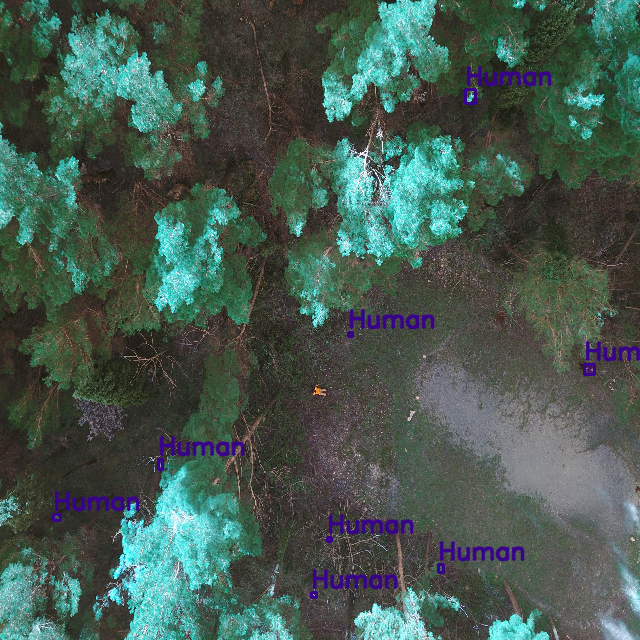

In [28]:
results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

In [29]:
cv2.imwrite('detections.png', detections)

True

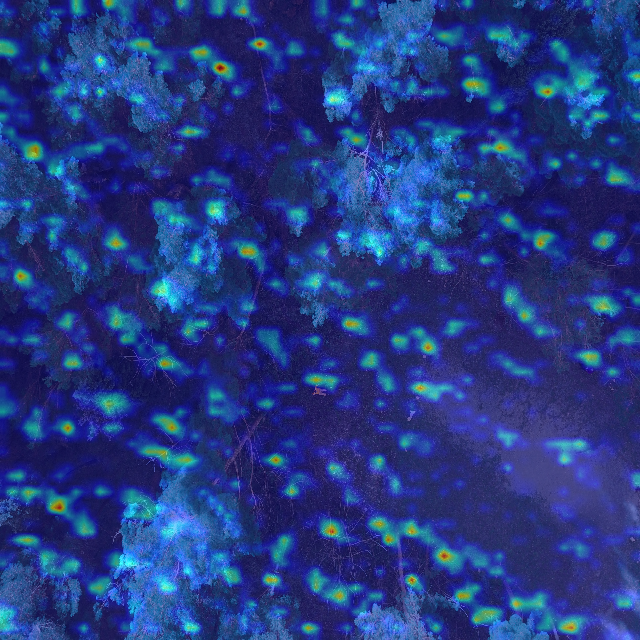

In [30]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

In [31]:
save_img = cam_image.copy()
save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('train_BRK_2052_P3.png', save_img)

True

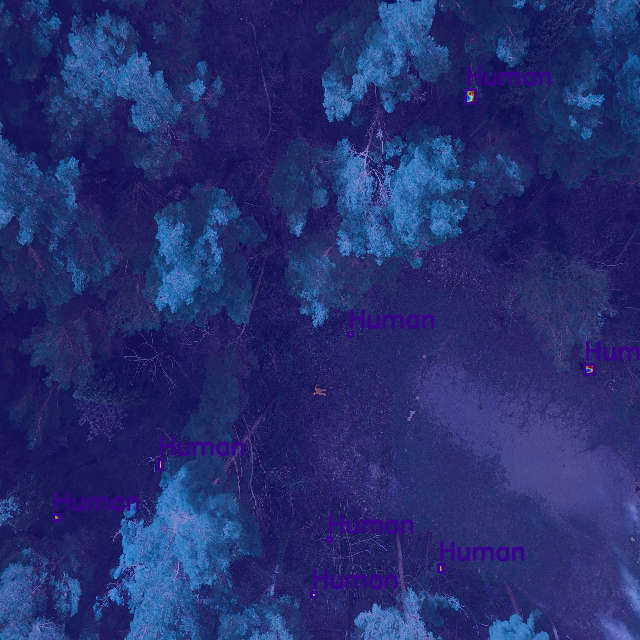

In [23]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

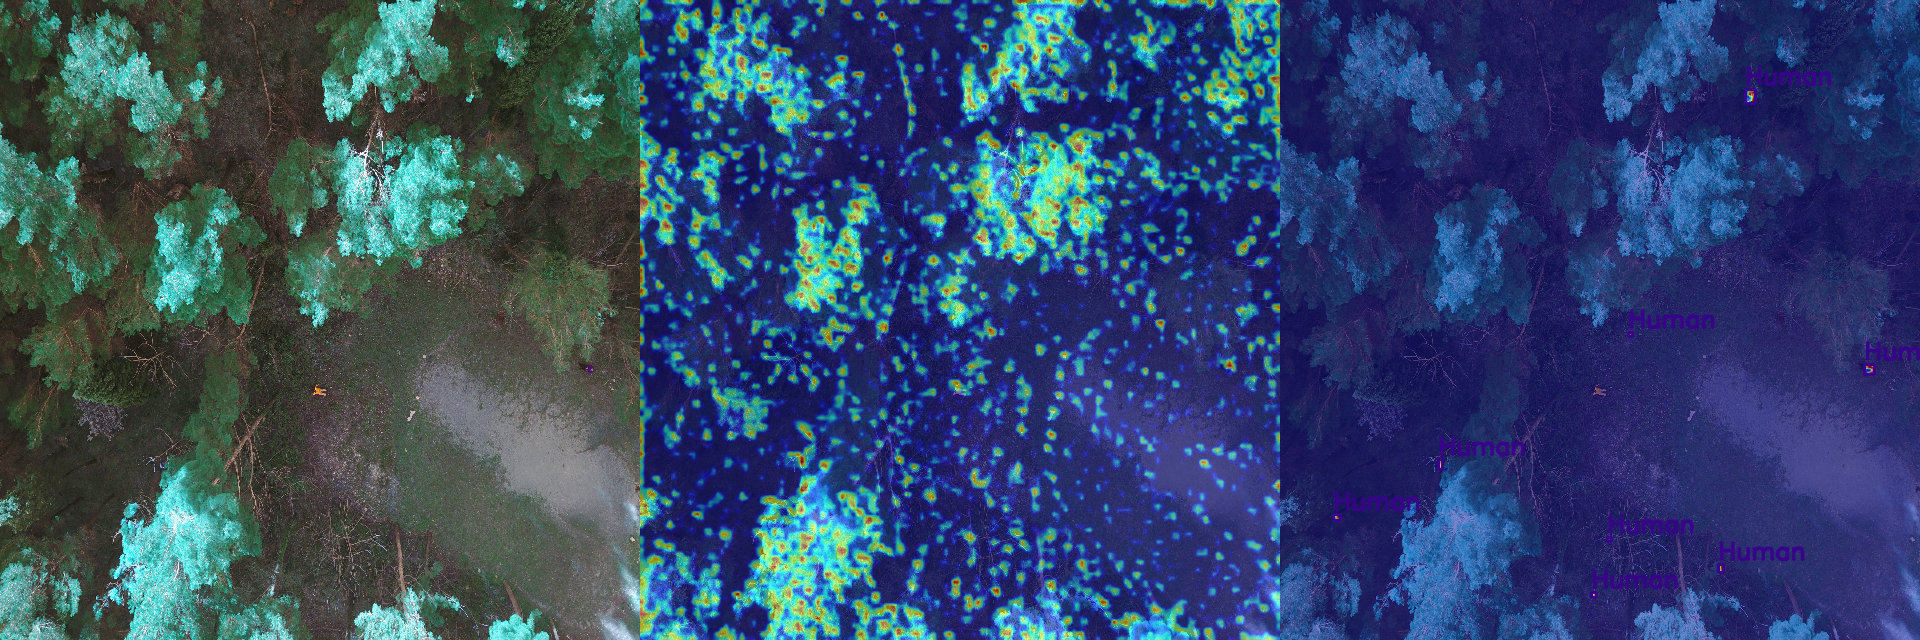

In [24]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))